<a href="https://colab.research.google.com/github/Paraskevi-KIvroglou/Finance_RAG_Implementation/blob/1-upload_notebook_from_colab/FinanceRAGAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project is inspired for this article. I would also try to use different models to see the difference.
https://pub.aimind.so/build-a-financial-due-diligence-rag-system-in-60-minutes-using-gemma-121905e1bfc3

In [1]:
# Installing required libraries
!pip install datasets pandas
!pip install pymongo sentence_transformers
!pip install -U transformers
!pip install accelerate

In [2]:
# Upgrade libraries
!pip install --upgrade huggingface_hub transformers

# Importing libraries
import huggingface_hub
from huggingface_hub import notebook_login

# Check version
print(f"Hugging Face Hub version: {huggingface_hub.__version__}")

# Log in to Hugging Face (this will prompt for your token)
notebook_login()

Hugging Face Hub version: 0.26.1


In [3]:
# import required libraries and import dataset

import pandas as pd
from datasets import load_dataset

#Load dataset

dataset = load_dataset("apardesi/ebitda_adj_synthetic")

#convert dataset to dataframe and explore

dataset_df = pd.DataFrame(dataset["train"])

dataset_df.sample(n=5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,type,caption,sector,description,frequency
53,Indebtedness,Convertible debt,All sectors,Debt that can be converted into equity under c...,15%
48,Indebtedness,Revolving credit facilities,All sectors,Credit lines that companies can draw upon for ...,50%
54,Indebtedness,Preferred stock,All sectors,Equity with fixed dividends that may be consid...,25%
5,EBITDA,Restructuring costs,All sectors,Costs incurred from reorganizing or restructur...,35%
7,EBITDA,Impairment charges,All sectors,Costs associated with the write-down of assets...,25%


In [4]:
#Data Cleaning and Data Preparation for the Agent
#dataset_df = dataset_df.dropna(subset=['caption'])

print("\\nNumber of missing values in each column after removal:")

print(dataset_df.isnull().sum())


dataset_df.sample(n=5)

\nNumber of missing values in each column after removal:
type           0
caption        0
sector         0
description    0
frequency      0
dtype: int64


,type,caption,sector,description,frequency
50,Indebtedness,Unsecured loans,All sectors,"Loans not backed by collateral, often with hig...",55%
35,Indebtedness,Pension liabilities,All sectors,Future obligations to fund employee pension pl...,80%
60,Indebtedness,Financial guarantees,All sectors,Obligations to guarantee financial performance...,35%
37,Indebtedness,Employee benefit liabilities,All sectors,Liabilities related to employee benefits such ...,75%
22,EBITDA,Covid-19 related adjustments,All sectors,"Adjustments due to the impact of Covid-19, suc...",30%


In [5]:
# Generate embeddings for our dataset. We will generate embeddings on the description column

from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("thenlper/gte-large")

def get_embedding(text: str) -> list[float]:
    if not text.strip():
        print("The text cell is empty")
        return []

    embedding = embedding_model.encode(text)

    return embedding.tolist()


dataset_df["embedding"] = dataset_df["description"].apply(get_embedding)

dataset_df.head()

,type,caption,sector,description,frequency,embedding
0,EBITDA,Non-recurring income,All sectors,Income that is not expected to recur in the fu...,40%,"[-0.006679772399365902, 0.00911914836615324, -..."
1,EBITDA,Non-recurring expenses,All sectors,Expenses that are not expected to recur in the...,50%,"[-0.007796823047101498, -0.019644632935523987,..."
2,EBITDA,Unrealized foreign exchange losses,All sectors,Losses from changes in foreign currency values...,30%,"[-0.019023926928639412, 0.0002458326634950936,..."
3,EBITDA,Unrealized foreign exchange gains,All sectors,Gains from changes in foreign currency values ...,30%,"[-0.014858296141028404, -0.0006147072999738157..."
4,EBITDA,Stock-based compensation,All sectors,Adjustments for compensation expenses paid in ...,45%,"[0.00024754265905357897, -0.021200427785515785..."


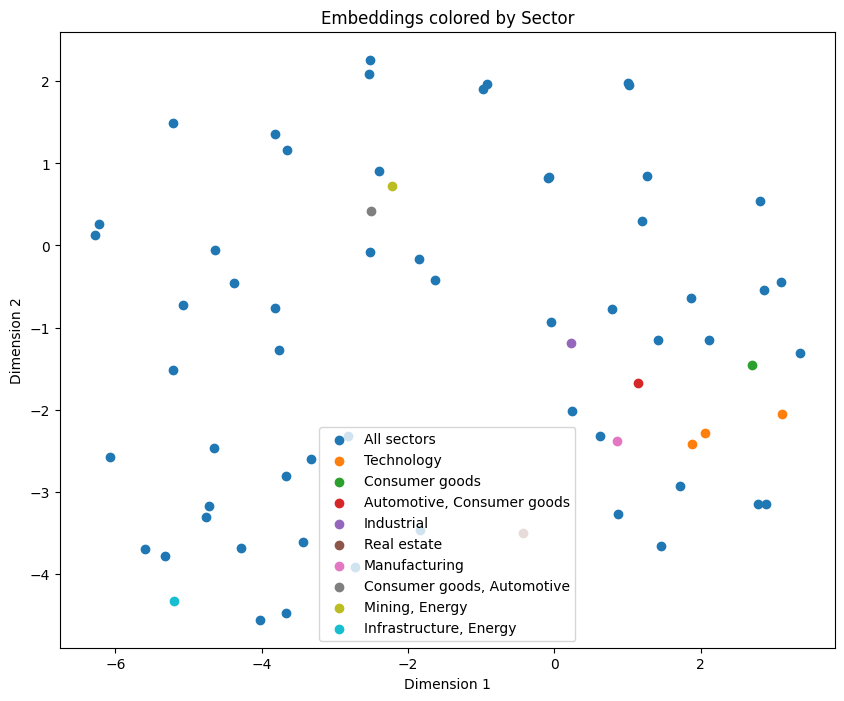

In [8]:
#Using dataframe dataset_df: Plot of embeddings created in comparison to their assigned sector from the database

import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming 'embedding' column contains list-like objects representing embeddings
# Convert embeddings to a suitable format for dimensionality reduction
embeddings = [emb for emb in dataset_df['embedding']]

# Reduce dimensionality of embeddings using TSNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(np.array(embeddings))

# Create a new DataFrame with reduced embeddings and sector
plot_df = pd.DataFrame({'x': reduced_embeddings[:, 0], 'y': reduced_embeddings[:, 1], 'sector': dataset_df['sector']})

# Plot the reduced embeddings colored by sector
plt.figure(figsize=(10, 8))
for sector in plot_df['sector'].unique():
  subset = plot_df[plot_df['sector'] == sector]
  plt.scatter(subset['x'], subset['y'], label=sector)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Embeddings colored by Sector')
plt.legend()
plt.show()

In [13]:
!python --version

Python 3.10.12


In [6]:
!pip install pymongo
!pip install --upgrade pymongo

In [7]:
#Ping Database deployment
from pymongo import MongoClient
from pymongo.server_api import ServerApi
from google.colab import userdata

uri = userdata.get('MONGO_URI')
# Create a new client and connect to the server
client = MongoClient(uri, server_api=ServerApi('1'))

# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [13]:
db = client["diligencedb"]
collection = db["diligence_collection"]

In [34]:
#Adding data to the collection
documents = dataset_df.to_dict("records")
collection.insert_many(documents)

print("Data added to MongoDB")

Data added to MongoDB


In [14]:
def vector_search(user_query, collection):

  #Generate embedding
  query_embedding = get_embedding(user_query)

  if query_embedding is None:
    return "Generation failed"

  #Define vector search pipeline

  pipeline = [
      {
          "$vectorSearch": {
                "index": "vector_index",
                "queryVector": query_embedding,
                "path": "embedding",
                "numCandidates": 20,
                "limit": 10,  # Return top 4 matches
          }
      },
      {
            "$project": {
                "_id": 0,  # Exclude the _id field
                "type": 1,
                "caption": 1,
                "sector" :1,
                "description":1,
                "frequency": 1,
                "score": {"$meta": "vectorSearchScore"},  # Include the search score
            }
      },
  ]

  # Perform search
  results = collection.aggregate(pipeline)
  return list(results)

In [15]:
# Handling queries
def get_search_result(query, collection):

  get_knowledge = vector_search(query, collection)

  search_result = ""
  for result in get_knowledge:
    search_result += f"Type: {result.get('type', 'N/A')}, Caption: {result.get('caption', 'N/A')}, Sector: {result.get('sector', 'N/A')}, Description: {result.get('description', 'N/A')}, Frequency: {result.get('frequency', 'N/A')} \n"

  return search_result

In [16]:
# Test query

query = "What are the top 3 EBITDA adjustments for technology sector and why? Please return items with Type: EBITDA only."
source_information = get_search_result(query, collection)
combined_information = f"Query: {query}\n{source_information}."

print(combined_information)

Query: What are the top 3 EBITDA adjustments for technology sector and why? Please return items with Type: EBITDA only.
Type: EBITDA, Caption: Covid-19 related adjustments, Sector: All sectors, Description: Adjustments due to the impact of Covid-19, such as government assistance programs and safety-related expenses. Counter argument by Buyer: Buyer may argue that these adjustments may set new operational standards and ongoing costs, hence should not be adjusted out. Strength: Medium., Frequency: 30% 
Type: EBITDA, Caption: Product development adjustments, Sector: Technology, Description: Adjustments for costs related to new product development. Counter argument by Buyer: Buyer may argue that these expenses reflect investment in future growth and innovation and should not be adjusted out. Strength: Weak., Frequency: 40% 
Type: EBITDA, Caption: Software development costs, Sector: Technology, Description: Adjustments for software development expenses that may be capitalized or expensed. C

In [17]:
from transformers import AutoTokenizer, AutoModelForCausalLM
def get_model_and_tokenizer(model_name):
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")

  return model, tokenizer

In [18]:
model, tokenizer = get_model_and_tokenizer("google/gemma-2-2b-it")

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

In [21]:
def get_query_response(query, model, tokenizer):
  gemma_query = f"{query} Continue to answer using the search results below:"
  combined_query = f"Query: {gemma_query}\n{source_information}."

  # Processing queries with Gemma

  input_ids = tokenizer(combined_query, return_tensors="pt").to("cuda")
  response = model.generate(**input_ids, max_new_tokens=1000)
  #print(tokenizer.decode(response[0]))
  return tokenizer.decode(response[0])

In [22]:
print(get_query_response("What are the top 3 EBITDA adjustments for Technology sector and explain why by each adjustment?", model, tokenizer))

<bos>Query: What are the top 3 EBITDA adjustments for Technology sector and explain why by each adjustment? Continue to answer using the search results below:
Type: EBITDA, Caption: Covid-19 related adjustments, Sector: All sectors, Description: Adjustments due to the impact of Covid-19, such as government assistance programs and safety-related expenses. Counter argument by Buyer: Buyer may argue that these adjustments may set new operational standards and ongoing costs, hence should not be adjusted out. Strength: Medium., Frequency: 30% 
Type: EBITDA, Caption: Product development adjustments, Sector: Technology, Description: Adjustments for costs related to new product development. Counter argument by Buyer: Buyer may argue that these expenses reflect investment in future growth and innovation and should not be adjusted out. Strength: Weak., Frequency: 40% 
Type: EBITDA, Caption: Software development costs, Sector: Technology, Description: Adjustments for software development expenses

In [27]:
def search_and_responce_queries(querySearch, questionQuery, model, tokenizer):
  source_information = get_search_result(querySearch, collection)

  gemma_query_ind = f"Based on the search results below, {questionQuery}"

  # Processing queries with model and tokenizer loaded from Hugging Face
  input_ids = tokenizer(combined_query_ind, return_tensors="pt").to("cuda")
  response = model.generate(**input_ids, max_new_tokens=1000)
  return tokenizer.decode(response[0])

In [28]:
print(search_and_responce_queries("What are 5 examples of Type Indebtedness with high frequency. Please return items with Type: Indebtedness",
                                  " explain why off-balance sheet obligations are important to consider as an Indebtedness item?", model, tokenizer))


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Query: Based on the search results below, explain why off-balance sheet obligations are important to consider as an Indebtedness item?
Type: Indebtedness, Caption: Debt, Sector: All sectors, Description: All forms of debt including loans, credit facilities, and bonds. Counter argument by Seller: Seller may argue that debt can be refinanced or restructured to reduce burden, and thus should be discounted in its impact. Strength: Medium., Frequency: 95% 
Type: Indebtedness, Caption: Unpaid interest, Sector: All sectors, Description: Interest expenses accrued but not yet paid. Counter argument by Seller: Seller may argue that unpaid interest can be managed through refinancing or negotiating repayment terms, hence should not be overly penalized. Strength: Medium., Frequency: 30% 
Type: Indebtedness, Caption: Overdrafts, Sector: All sectors, Description: Negative balances in bank accounts that need to be repaid. Counter argument by Seller: Seller may argue that overdrafts ar

In [26]:
model, tokenizer = get_model_and_tokenizer("meta-llama/Llama-3.2-1B-Instruct")

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]